# Gardner's Expression Regressed

So your exploration manager says she needs a volume of pseudo-density for modeling.  She gives you well logs from the basin with density and delta-t curves.  Being a smart geophysicist, you immediately say "I can just use Gardner's equation $\rho=0.23V_{P}^.25$."  You convert your delta-t curves into velocity curves, calculate rho from the equation, and compare to the density curve in the log.  But something is wrong.  The curves don't match.  What to do?

One option is to linearize the equation and do a regression for the 2 parameters.  This ipython notebook will show you how.

Start with the general equation:
$$\rho = \alpha * V_{P}^\beta$$

Take the natural log of both sides:
$$ln(\rho) = ln(\alpha * V_{P}^\beta)$$

Use the properties of logarithms to make a linear equation:
$$ln\rho = ln\alpha + ln(V_{P}^\beta)$$
$$ln\rho = ln\alpha + \beta*lnV_{P}$$

Rewrite:
$$D = A + BV$$

where A is the intercept, B is the slope, V is the independent variable, and D is the dependent variable.

In [2]:
# import 3rd party libraries
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# import local library
from las import LASReader

Read the las file and load into a pandas dataframe (because they are awesome), calculate P-wave velocity from delta-t curve, and extract density and velocity to new numpy arrays.

In [4]:
# import las file (see creating a synthetic ipython notebook)
L30 = LASReader('L-30.las', null_subs=np.nan)

# load log data into pandas dataframe
L30_df = pd.DataFrame(L30.data2d, columns=L30.curves.names, index=L30.data['DEPTH'])

# Create calculated Logs: P-wave Velocity from Sonic and P-wave Normal Incidence Impedance
# Assumes the dt curve is in standard units microseconds per foot and we want to convert to feet per second
L30_df['PVEL'] = (1/L30_df['DT'])*1e6
L30_df['PNII'] = L30_df['RHOB']*L30_df['PVEL']

# create 1D arrays of density and p-wave velocity from pandas dataframe
rhob = np.array(L30_df['RHOB'])
pvel = np.array(L30_df['PVEL'])

Now, because the two curves do not always have the same depth interval, we will write a for loop to determine the first index (corresponding to some depth) such that a value (not a nan) exists for both curves.  Then do the same for the last index.  I have chosen to create two new curves marked 'X' that only contains the interval where there are no nans above and no nans below.  Note, if there is an interval within the log that contains nans for whatever reason (like your petrophysicist edited them out because of a washout zone or just a general lack of confidence in teh values), these logs will still have those nans.  A better program(er) would have try and except clauses to verify this.

In [5]:
# Determine the index range for which both values are not nan's
# starting index
for i in range(0,len(L30_df.index)+1):
    if np.isnan(rhob[i]) == False and np.isnan(pvel[i]) == False:
        first_index = i
        break

# ending index
for j in range(0,len(L30_df.index)+1):
    if np.isnan(rhob[-j]) == False and np.isnan(pvel[-j]) == False:
        last_index = len(L30_df.index) - j
        break

rhobX = rhob[first_index:last_index:1]
pvelX = pvel[first_index:last_index:1]

Create your first crossplot.

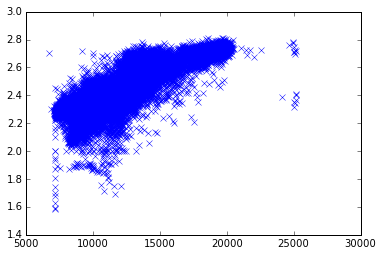

In [6]:
# Create a crossplot of pvel vs rhob
plt.plot(pvelX, rhobX, 'bx')
plt.show()

Maybe this log needs to be edited.  There are many outliers, but let's move forward as if this were a good set of logs.  We are just trying to understand the principle here anyway, right?

Now we setup our arrays for the linear regression.

In [7]:
# create new 1D arrays of the natural log of density and p-wave velocity
D = np.log(rhobX)
V = np.log(pvelX)

Create another crossplot.  This one 'should' be more linear.

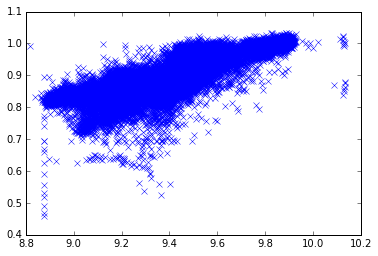

In [8]:
# create a crossplot of V vs D
plt.plot(V, D, 'bx')
plt.show()

Setup the regression using scipy.stats.

In [13]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
B, A, r_value, p_value, std_err = stats.linregress(V,D)
#
print A # intercept
print B # slope

-1.15556516696
0.217620072993


Create pseudo-density values from the regression and crossplot again.

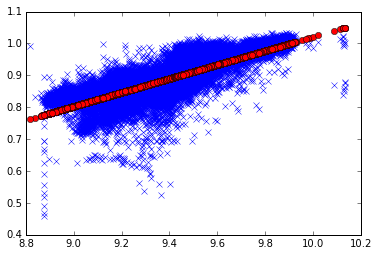

In [17]:
D_reg = A + B * V

# plot the regression
plt.plot(V, D, 'bx')
plt.plot(V, D_reg, 'ro')
plt.show()

Finally work backwards to get alpha and beta using a property of natural logs $e^{ln(c)} = c$ and then plot.

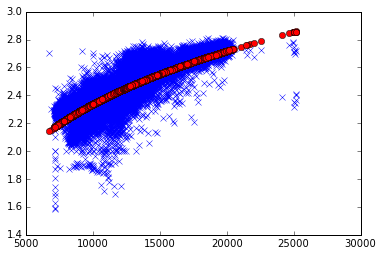

In [15]:
# calculate alpha and beta from A and B
alpha = np.exp(A)
beta = B

# Estimate the density (rhobCALC) from velocity
rhobCalc = alpha * (pvelX**beta)

# crossplot D and V and draw a line from the predicted values
plt.plot(pvelX, rhobX, 'bx')
plt.plot(pvelX, rhobCalc, 'ro')
plt.show()

To check the values:

In [16]:
print alpha
print beta

0.314879527099
0.217620072993


Obviously the regression could be improved by editing the input logs, but overall, it is a good fit.  If you really wanted to be fancy, you could do a regression for each stratigraphic interval.  This is based on the idea that each stratigraphic unit has a unique velocity/density relationship from other stratigraphic units in the basin.  To my knowledge, this has not been tested, so please let me know if you find a paper that discussed this.  Thanks.

Let's go back to the beginning of the post when your exploration manager asked for a pseudo-density volume.  How do you use the information above to deliver this?  Well, one method would be to take an interval velocity model (whether from tomography or converted RMS using Dix) and create the pseudo-density attribute using a "tracemath"-like module or whatever you have available in your processing package.  This is done regularly in the inversion workflow for forward modeling. 

Below is a list of great articles and books related to the subject:

Castagna, J. P., and M. M. Backus, 1993, Offset-dependent reflectivity - Theory and practice of AVO analysis: SEG Investigations in Geophysics No. 8.

Gardner,  G. H., Gardner, L. W., Gregory, A. R., 1974, Formation velocity and density - the diagnostic basics for stratigraphic traps. GEOPHYSICS: 39, 770-780.

Gregory, A. R., 1977, Aspects of rock physics from laboratory and log data that are important to seismic interpretation.  Seismic Stratigraphy - applications to hydrocarbon exploration: AAPG Memoir 26.